# U-Net Training Example Notebook
#### UCSD/SDSC June 9, 2019
##### Author: Dylan Uys

This notebook shows a simple example of training a U-Net

##  1) Set up Data Generators

In [1]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:
from py_unet.utils.data_utils import get_split_dirs
from py_unet.data_generator import DataGenerator

### First, create lists of patient directories for training, validation and testing.

* `py_unet`.`data_utils`.`get_split_dirs` can help with this
* `data_dirs` is a list of directories, each of which contains patient directories
* Each patient directory should contain Numpy files with the extension `_image.npy` for images and `_mask.npy` for labels

In [3]:
import numpy as np
import os

In [63]:
# data_dirs = ['data/preprocessed/']
# split = [0.75, 0.15, 0.10]
# data_dirs = ['data/single/']
# split = [.85, .15, 0]

# train_dirs, val_dirs, test_dirs = get_split_dirs(data_dirs, split=split)
train_dirs =val_dirs = test_dirs = 'data/preprocessed/00013'
# mask_fname = '{}_mask.npy'.format('00000')
# np.unique(np.load(os.path.join(train_dirs[1], mask_fname)))

In [5]:
no_smoke = ['data/preprocessed/00047','data/preprocessed/00048','data/preprocessed/00049','data/preprocessed/00050',\
            'data/preprocessed/00051','data/preprocessed/00052','data/preprocessed/00053','data/preprocessed/00054',\
           'data/preprocessed/00055','data/preprocessed/00056','data/preprocessed/00057','data/preprocessed/00058',\
           'data/preprocessed/00059','data/preprocessed/00060','data/preprocessed/00061','data/preprocessed/00062',\
           'data/preprocessed/00063']

train_dirs.sort()
val_dirs.sort()
test_dirs.sort()

train_dirs[0], test_dirs[-1] = test_dirs[-1], train_dirs[0]
train_dirs[1], test_dirs[-2] = test_dirs[-2], train_dirs[1]

In [6]:
print(sum(x in train_dirs for x in no_smoke)/len(train_dirs))
print(sum(x in val_dirs for x in no_smoke)/len(val_dirs))
print(sum(x in test_dirs for x in no_smoke)/len(test_dirs))

0.25
0.3333333333333333
0.2857142857142857


### Then, create a `DataGenerator` for each partition

    
* At a minimum, you must set the `directories` argument (but you probably also want to set `batch_size` and `image_dims`)
    * Rather than loading all images and masks at once, the generator will store absolute filepaths to all the images it finds in `directories`
    
   
* This class is compatible with `fit_generator` and `predict_generator` in Keras
    * These methods use `__getitem__` and `__len__` to interact with the generator, which inherits from `Keras.utils.Sequence`
        * `__len__` corresponds to the number of batches in the generator (there's also the `n_samples` property for convenience) 
        * When `__getitem__` is invoked, a batch of images and masks are loaded 
            * These will be Numpy matrices with shape `(batch, image_dims[0], image_dims[1], 1)`
        * `on_epoch_end` is another piece of Keras functionality, which this class uses to shuffle the filenames after every training epoch




    

Finished loading: 1 batches, 1 samples
Finished loading: 1 batches, 1 samples
Finished loading: 1 batches, 1 samples


<Figure size 432x288 with 0 Axes>

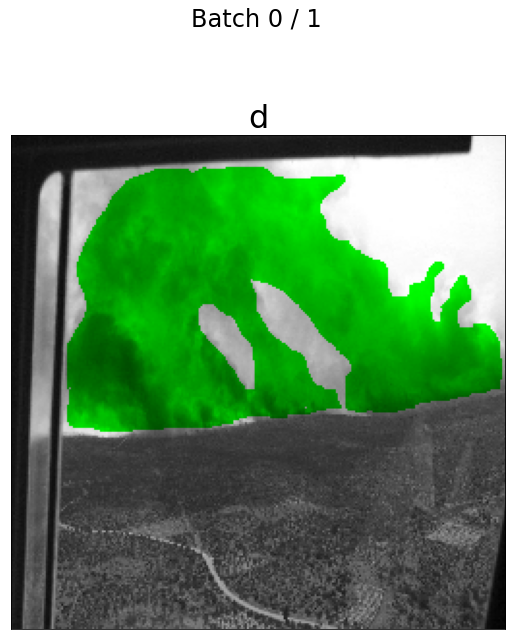

<Figure size 432x288 with 0 Axes>

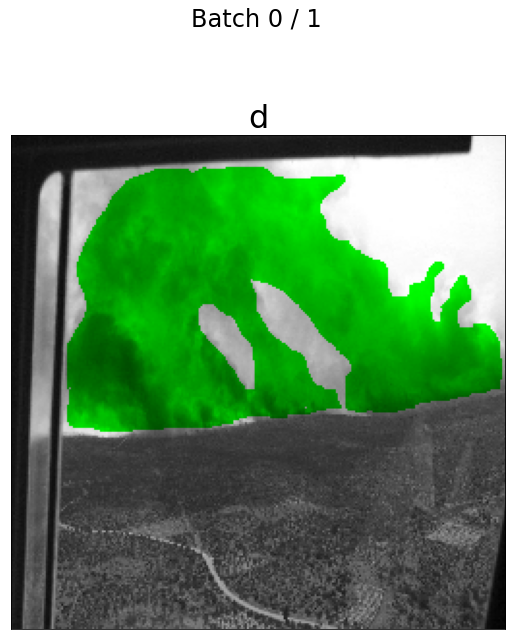

<Figure size 432x288 with 0 Axes>

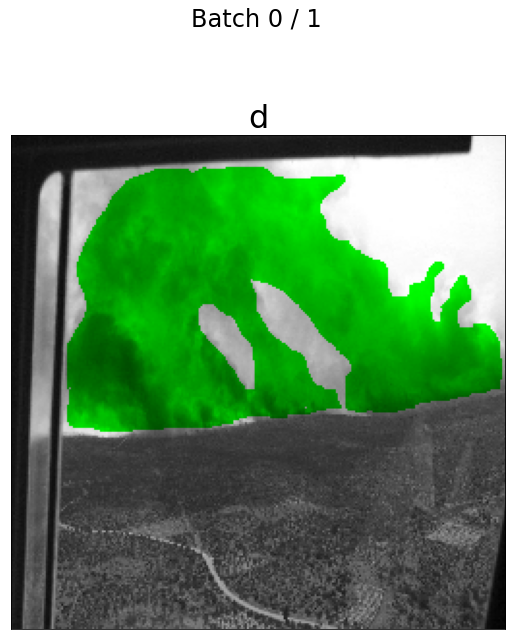

In [64]:
image_dims = (256, 256)
batch_size = 1

train_gen = DataGenerator(train_dirs, batch_size, image_dims, n_channels=3, use_augmentation=False)
val_gen = DataGenerator(val_dirs, batch_size, image_dims, n_channels=3, use_augmentation=False)
test_gen = DataGenerator(test_dirs, batch_size, image_dims, n_channels=3, use_augmentation=False)

# Inspect a batch to make sure we didn't screw up
train_gen.show_batch()
val_gen.show_batch()
test_gen.show_batch()
# test_gen.show_batch(1)
# test_gen.show_batch(2)

In [65]:
# from py_unet.batch_augmentor import BatchAugmentor
# default_args = { 
#             'add_gaussian_noise': (0.5, (0.01,0.1)),            
#             'horizontal_flip':    (0.5,),
#             'vertical_flip':      (0.5,),
#             'rotate':             (0.5, (-45,45)),
#             'shear':              (0.5, (.05, 2.)),
#             'shift':              (0.5, (-0.05, 0.05), (-0.05, 0.05)),
#             'zoom':               (0.5, (0.95, 1.05)),
#         }
# aug = BatchAugmentor(default_args, batch_size)
# aug.process_batch()

## 2) Build a U-Net

In [66]:
from keras.optimizers import Adam

from py_unet import ModelMGPU, device_config
from py_unet.unet_builder import UnetBuilder
from py_unet.utils.metric_utils import bce_dice_loss, dice_coef

from sklearn.model_selection import cross_val_score, cross_val_predict

### Make the tensorflow backend aware of compute devices 

* `py_unet`.`device_utils`.`device_config` uses tensorflow library functions to find available compute devices, and returns the number of available GPUs
* If GPUs are available, Keras is made aware of this by setting the `CUDA_VISIBLE_DEVICES` environment variable
* More on multi-gpu stuff below...


In [67]:
n_gpus = device_config(verbose=True)

print('\n{} GPUs found'.format(n_gpus))
n_gpus = 1

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3641693271999937602
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9343703900335003719
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11623805292228274264
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7882519360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3378033131004092257
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:05:00.0, compute capability: 6.1"
]

2 GPUs found


### Configure a  `UnetBuilder`  to match your desired architecture


Importat arguments:
* `input_dim`: This should be (rows, cols, channels), corresponding to the Keras backend setting `data_format='channels_last'`
* `ds_filter_counts`: Number of convolutional filters to use for layers in each block of the U-net's contracting bath. 

    For example, [8, 16, 32, 64, 128]  will build a U-Net with 9 blocks, where 
       ds_filter_counts[:-1] corresponds to a 4 block contracting path,
       ds_filter_counts[-1] corresponds to the bottleneck block, and 
       ds_filter_counts[::-1]  corresponds to a 4 block expanding path.
       
* `n_gpus`: The model will be parallelized to this many GPUs if > 1, otherwise, no action is taken.
    * To see how simple Keras makes this, see `py_unet`.`utils`.`device_utils` for the `ModelMGPU` class


* See `unet_builder.py` for more options like `dropout`, `batch_norm`, etc. 




    

In [68]:
input_dim = image_dims + (3,)
ds_filter_counts = [32, 64, 128, 256, 512] 
dropout = True 

model_builder = UnetBuilder(input_dim, 
#                             ds_filter_counts, 
                            dropout=dropout,
                            n_gpus=n_gpus)

before: 1


### Build and compile your model

* Here, you can simply call yourUnetBuilderInstance.`build()` to get a model. 
* Then, compile it with the desired optimizer, loss and metrics. 

* Note that if `n_gpus` > 1, this model will be an instance of the `ModelMGPU` class
    * This hides away your model's actual layers
    * If you want to get your original model (for saving or whatever), pass this model as an argument to `get_inner_model` (found in  `py_unet`.`utils`.`model_utils`)



In [69]:
model = model_builder.build()

1


In [70]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 256, 256, 8)  216         input_4[0][0]                    
__________________________________________________________________________________________________
activation_69 (Activation)      (None, 256, 256, 8)  0           conv2d_69[0][0]                  
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 256, 256, 8)  0           activation_69[0][0]              
____________________________________________________________________________________________

In [71]:
model.compile(optimizer=
#               'adam',
              Adam(lr=0.0005), 
              loss=bce_dice_loss,  
              metrics=[bce_dice_loss, dice_coef])

## 3) Train or Load State

In [72]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from datetime import datetime

from py_unet.utils.model_utils import load_model, load_model_state, save_model, save_model_state
from py_unet.utils.plot_utils import plot_train_histories

In [73]:
train = True

### Option 1: Load the weights and optimizer of a trained model

* There are multiple ways to load a trained model, but since we use a custom loss function, we're limited to just a couple. 
* We already built and compiled a model, so we'll simply load the weights and optimizer state of a previously saved model.
    * This can be accomplished by calling `load_model_state` 
    * The model whose weights/optimizer you load must have the same architectural configuration as the model you defined
* If you want to instead load a whole model including it's architecture, see `load_model` (both functions defined in `py_unet`.`utils`.`model_utils`)

In [74]:
model_name = 'demo_model'
model_dir = 'models'


if not train:
    model = load_model_state(model, model_name, model_dir)

### Option 2: Train your model


In [75]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17836555723655205822
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16091574268791510084
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9749705884397237807
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7882519360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17154478042464113929
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:05:00.0, compute capability: 6.1"
]


In [76]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.2369 - bce_dice_loss: 1.1441 - dice_coef: 0.5446
Epoch 00001: saving model to best_model.h5
1/1 [==============================] - 10s 10s/step - loss: 1.2369 - bce_dice_loss: 1.1441 - dice_coef: 0.5446 - val_loss: 1.2302 - val_bce_dice_loss: 1.1387 - val_dice_coef: 0.5514 - lr: 5.0000e-04
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 1.2348 - bce_dice_loss: 1.1432 - dice_coef: 0.5458
Epoch 00002: saving model to best_model.h5
1/1 [==============================] - 10s 10s/step - loss: 1.2348 - bce_dice_loss: 1.1432 - dice_coef: 0.5458 - val_loss: 1.2287 - val_bce_dice_loss: 1.1384 - val_dice_coef: 0.5519 - lr: 5.0000e-04
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 1.2329 - bce_dice_loss: 1.1426 - dice_coef: 0.5468
Epoch 00003: saving model to best_model.h5
1/1 [==============================] - 6s 6s/step - loss: 1.2329 - bce_dice_loss: 1.1426 - dice_coef: 0.5468 - val_loss

Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 1.1959 - bce_dice_loss: 1.1318 - dice_coef: 0.5519
Epoch 00024: saving model to best_model.h5
1/1 [==============================] - 12s 12s/step - loss: 1.1959 - bce_dice_loss: 1.1318 - dice_coef: 0.5519 - val_loss: 1.1940 - val_bce_dice_loss: 1.1309 - val_dice_coef: 0.5559 - lr: 5.0000e-04
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 1.1937 - bce_dice_loss: 1.1307 - dice_coef: 0.5520
Epoch 00025: saving model to best_model.h5
1/1 [==============================] - 7s 7s/step - loss: 1.1937 - bce_dice_loss: 1.1307 - dice_coef: 0.5520 - val_loss: 1.1921 - val_bce_dice_loss: 1.1301 - val_dice_coef: 0.5562 - lr: 5.0000e-04
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 1.1899 - bce_dice_loss: 1.1279 - dice_coef: 0.5527
Epoch 00026: saving model to best_model.h5
1/1 [==============================] - 1s 1s/step - loss: 1.1899 - bce_dice_loss: 1.1279 - dice_coef: 0.5527 - val_los

Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.9179 - bce_dice_loss: 0.8665 - dice_coef: 0.6282
Epoch 00047: saving model to best_model.h5
1/1 [==============================] - 8s 8s/step - loss: 0.9179 - bce_dice_loss: 0.8665 - dice_coef: 0.6282 - val_loss: 1.1400 - val_bce_dice_loss: 1.0888 - val_dice_coef: 0.5697 - lr: 5.0000e-04
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.9133 - bce_dice_loss: 0.8622 - dice_coef: 0.6354
Epoch 00048: saving model to best_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.9133 - bce_dice_loss: 0.8622 - dice_coef: 0.6354 - val_loss: 1.1310 - val_bce_dice_loss: 1.0800 - val_dice_coef: 0.5724 - lr: 5.0000e-04
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 0.9108 - bce_dice_loss: 0.8598 - dice_coef: 0.6363
Epoch 00049: saving model to best_model.h5
1/1 [==============================] - 14s 14s/step - loss: 0.9108 - bce_dice_loss: 0.8598 - dice_coef: 0.6363 - val_los

Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.8255 - bce_dice_loss: 0.7779 - dice_coef: 0.6645
Epoch 00070: saving model to best_model.h5
1/1 [==============================] - 2s 2s/step - loss: 0.8255 - bce_dice_loss: 0.7779 - dice_coef: 0.6645 - val_loss: 1.1097 - val_bce_dice_loss: 1.0622 - val_dice_coef: 0.5786 - lr: 5.0000e-04
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.8224 - bce_dice_loss: 0.7749 - dice_coef: 0.6660
Epoch 00071: saving model to best_model.h5
1/1 [==============================] - 1s 913ms/step - loss: 0.8224 - bce_dice_loss: 0.7749 - dice_coef: 0.6660 - val_loss: 1.1201 - val_bce_dice_loss: 1.0728 - val_dice_coef: 0.5757 - lr: 5.0000e-04
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.8300 - bce_dice_loss: 0.7826 - dice_coef: 0.6622
Epoch 00072: saving model to best_model.h5
1/1 [==============================] - 3s 3s/step - loss: 0.8300 - bce_dice_loss: 0.7826 - dice_coef: 0.6622 - val_lo

1/1 [==============================] - 9s 9s/step - loss: 0.6834 - bce_dice_loss: 0.6370 - dice_coef: 0.7186 - val_loss: 1.1160 - val_bce_dice_loss: 1.0696 - val_dice_coef: 0.5786 - lr: 5.0000e-06
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.6769 - bce_dice_loss: 0.6305 - dice_coef: 0.7209
Epoch 00093: saving model to best_model.h5
1/1 [==============================] - 15s 15s/step - loss: 0.6769 - bce_dice_loss: 0.6305 - dice_coef: 0.7209 - val_loss: 1.1163 - val_bce_dice_loss: 1.0699 - val_dice_coef: 0.5785 - lr: 5.0000e-06
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.6731 - bce_dice_loss: 0.6267 - dice_coef: 0.7185
Epoch 00094: saving model to best_model.h5
1/1 [==============================] - 8s 8s/step - loss: 0.6731 - bce_dice_loss: 0.6267 - dice_coef: 0.7185 - val_loss: 1.1166 - val_bce_dice_loss: 1.0702 - val_dice_coef: 0.5784 - lr: 5.0000e-06
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 0.6665 - bce_di

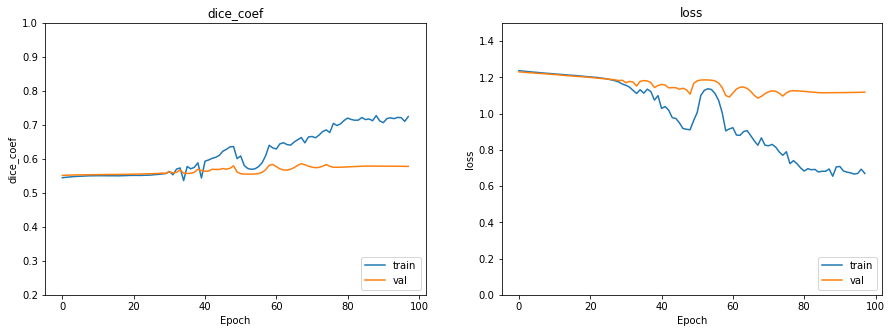

In [77]:
if train:
    callbacks = [
        EarlyStopping(monitor='val_bce_dice_loss', mode='min',
                      patience=30, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,
                          verbose=1, mode='auto', min_delta=0.00001),
        ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto',  save_freq='epoch', verbose=1)
    ]
    
    epochs = 100
    
    start_time = datetime.now()
    train_history = model.fit_generator(train_gen,
#                                         steps_per_epoch=len(TRAIN_IMGS) // batch_size,
                                        epochs=epochs,
                                        validation_data=val_gen,
#                                         validation_steps=len(TEST_IMGS) // batch_size,
                                        callbacks=callbacks)
#                                        )
    train_time = datetime.now() - start_time
    
    # Display training time and dice/loss curves
    print('Training took {} seconds'.format(train_time.total_seconds()))
    plot_train_histories(train_history, ['dice_coef', 'loss'], loss_ylim=[0, 1.5], metric_ylim=[0.2,1]) 

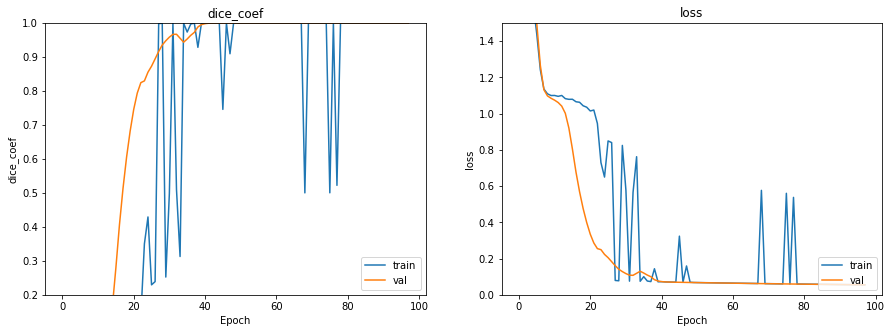

In [19]:
plot_train_histories(train_history, ['dice_coef', 'loss'], loss_ylim=[0, 1.5], metric_ylim=[0.2,1])

In [22]:
save = False
model_name = 'fulldata'

if save:
    save_model(model, model_name, model_dir)

## 4) Evaluate your model

In [78]:
from py_unet.utils.eval_utils import evaluate_model
from py_unet.utils.plot_utils import plot_dice, display_pred_comparison

Evaluate the model, the dict `results` will contain metrics like precision, recall, dice score and predict_time

In [79]:
results = evaluate_model(model, test_gen.load_all(), sort_results=True)
print(results.keys())

	precision: 0.3944434639887262
	recall: 0.999851999810031
	dice: 0.5657123644495735
	Predict time (s): 0.243479
dict_keys(['dice_scores', 'precisions', 'recalls', 'filenames', 'X', 'Y', 'predictions', 'probabilities', 'predict_time', 'dice', 'precision', 'recall'])


Plot the frequency distribution of dice scores on the test set

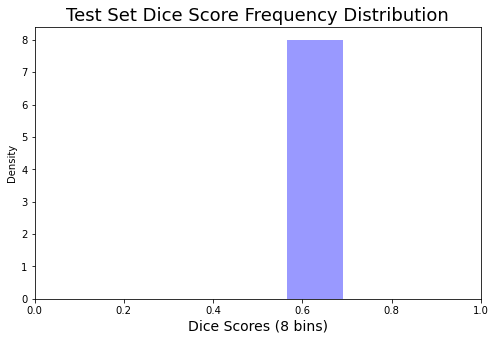

(0.5657123644495735,)

In [80]:
plot_dice(results['dice_scores'], bins=8)
results['dice_scores']

* Compare predicted contours with ground truth
* The leftmost subfig uses green for true positives, red for false positives, blue for false negatives, white for true negatives.
* If `sort_results`=True in previous call to `evaluate_model`, -1 will be the index of the best prediction, and 0 the worst


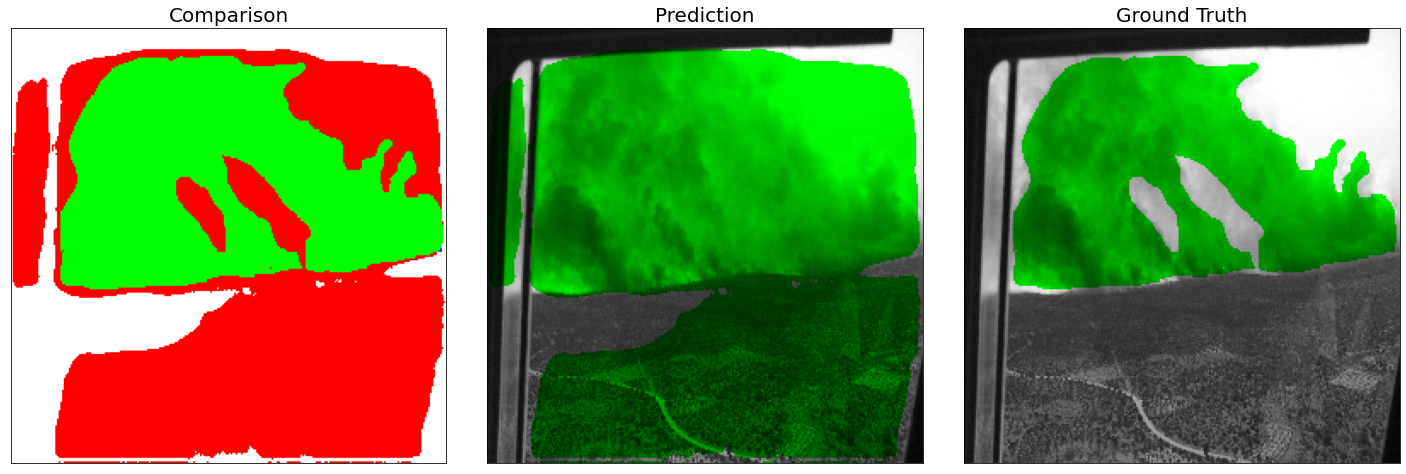

In [81]:
# for i in range(len(results['Y'])):
i = -1
truth = results['Y'][i]
pred = results['predictions'][i]
img = results['X'][i]

display_pred_comparison(truth, pred, img);


In [27]:
len(results['predictions'][0])

256